# Data Generation and Analysis Workshop
## Tuesday Oct 8, 2024: Simulation in-depth
## Simulating and analysing stochastic gravitational wave backgrounds with LISA

This tutorial is divided into five sections devoted to:

1. The installation of the necessary packages of the LISA Simulation Suite and
other analysis tools.
2. The generation of LISA orbits.
3. The simulation of LISA's measurements of stochastic gravitational wave backgrounds (SGWB).
4. The simulation of LISA's instrumental noise.
5. The simple analysis of the simulated data.

## 1. Installing the required packages from the LISA Simulation Suite

* LISA Constants
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.10355948.svg)](https://doi.org/10.5281/zenodo.10355948)
* LISA Orbits (documentation [here](https://lisa-simulation.pages.in2p3.fr/orbits/html/latest/))
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.10136689.svg)](https://doi.org/10.5281/zenodo.10136689)
* LISA Instrument
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.10136689.svg)](https://doi.org/10.5281/zenodo.10136689)
* LISA GW Response (documentation [here](https://lisa-simulation.pages.in2p3.fr/gw-response/master/))
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.8321733.svg)](https://doi.org/10.5281/zenodo.8321733)
* pyTDI (documentation [here](https://lisa.pages.in2p3.fr/LDPG/wg6_inrep/pytdi/master/))
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.8429119.svg)](https://doi.org/10.5281/zenodo.8429119)



In [ ]:
# LISA Constants
!pip install lisaconstants
# LISA Orbits
!pip install lisaorbits
# !pip install -v "lisaorbits==2.3"
# LISA Instrument
!pip install lisainstrument
# LISA GW Response
!pip install lisagwresponse
# pyTDI
!pip install pytdi

In [ ]:
# Install a tool to compute phase transition spectra
!pip install --upgrade git+https://dweir@bitbucket.org/dweir/ptplot.git

In [ ]:
# Install backgrounds analysis tool
!pip install backgrounds

## 2. Generate an orbit file


In [ ]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import lisaconstants
from h5py import File

from scipy.signal import welch
from scipy.interpolate import interp1d
import backgrounds

from ptplot.science.calculate_powerspectrum import PowerSpectrum
from lisaorbits import EqualArmlengthOrbits
from lisagwresponse import StochasticBackground, psd
from pytdi import Data, michelson, ortho

logging.basicConfig(level=logging.INFO)

In [ ]:
# Create directory for outputs
!mkdir data

In [ ]:
# Set directory for outputs
BASEDIR = './data'
# Set to true for quick tests
PT_ALPHA = np.float64(os.environ.get('PT_ALPHA', '0.1'))

In [ ]:
# Set the orbit simulation duration
a_day = 24 * 3600 # s
a_year = 365.25 * a_day # s
duration = a_year
# Set orbit initial and sampling time
orbits_t0 = 0
orbits_dt = 10000
# We use a 2 year orbit (to allow for margin)
orbits_size = int(duration// orbits_dt) + 1
orbits_path = os.path.join(BASEDIR, 'orbits.h5')
# Create an orbit object
# orbits = EqualArmlengthOrbits(
#     dt=orbits_dt,
#     size=orbits_size,
#     t0=orbits_t0,
# )
orbits = EqualArmlengthOrbits(
    t_init=orbits_t0,
)

In [ ]:
# Remove file if it exists
if os.path.exists(orbits_path):
    os.remove(orbits_path)
# Generate and write orbit file
orbits.write(orbits_path, dt=orbits_dt, size=orbits_size, mode='w')

In [ ]:
# Read orbit file
with File(orbits_path, 'r') as hdf:

    # assert orbits.t_init == hdf.attrs['t0']
    # assert orbits.dt == hdf.attrs['dt']
    # assert orbits.size == hdf.attrs['size']
    t = orbits_t0 + np.arange(0, orbits_size) * orbits_dt

    sc_positions = hdf['tcb/x'][:]
    ltts = hdf['tcb/ltt'][:]
    pprs = hdf['tps/ppr'][:]

    plt.figure(figsize=(12, 9))
    plt.subplot(311)
    for i, coord in enumerate('xyz'):
        plt.plot(t, sc_positions[:, 0, i], label=rf'${coord}$')
    plt.ylabel('Spacecraft 1 [m]')
    plt.title('Spacecraft positions')
    plt.legend()
    plt.subplot(312)
    for i, coord in enumerate('xyz'):
        plt.plot(t, sc_positions[:, 1, i], label=rf'${coord}$')
    plt.ylabel('Spacecraft 2 [m]')
    plt.legend()
    plt.subplot(313)
    for i, coord in enumerate('xyz'):
        plt.plot(t, sc_positions[:, 2, i], label=rf'${coord}$')
    plt.ylabel('Spacecraft 3 [m]')
    plt.xlabel('Time [s]')
    plt.legend()

    plt.figure(figsize=(12, 4))
    plt.subplot(111)
    plt.plot(t, ltts)
    plt.ylabel('LTT [s]')
    plt.xlabel('Time [s]')
    plt.title('Light travel time')

## 3. Simulate LISA's response to a stochastic background

### 3.1 Define the stochastic background

We use `ptplot` [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.6949107.svg)](https://doi.org/10.5281/zenodo.6949107) (<https://www.ptplot.org>,
 Weir 2023) to compute the energy density power spectrum of a stochastic background due to first-order phase transitions (see Caprini et al 2021).

We use values used in Fig. 6 of the Cosmology with LISA white paper (SNR of 10):

$$v_w = 0.9,$$
$$\alpha = 0.1,$$
$$\beta / H = 50,$$
$$T_\star = 200 \, \text{GeV},$$
$$g_\star = 100.$$

The tools gives $h^2 \Omega(f)$. We convert to a one-sided power density spectral density with

$$S_h(f) = h^2 \Omega(f) \frac{3 (H_0/h)^2}{4 \pi^2 f^3},$$

with $H_0/h = 100 \, \text{km} \text{s}^{-1} \text{Mpc}^{-1} \approx 3.24 \times 10^{-18} \text{s}^{-1}$.

We can compute the total energy in the sky and divide up into $N$ pixels, and 2 polarizations, to get the energy in each pixel,

$$S_\text{pixel}(f) = \frac{4 \pi}{2 N} S_h(f).$$

In [ ]:
# We offset the signal t0 to have orbits information at emission time
response_t0 = orbits_t0 + 1000.0 # seconds
response_fs = 0.5 # Hz
response_dt = 1 / response_fs
# Generate 1 year dataset
response_duration = a_day
response_size = int(response_duration // response_dt) + 1
response_nside = 4
response_npix = hp.nside2npix(response_nside)
response_path = os.path.join(BASEDIR, 'response.h5')
# Specifications of the stochastic background origin
# Specifications of the stochastic background (energy density)
spectrum = PowerSpectrum(vw=0.9, alpha=PT_ALPHA, BetaoverH=50, Tstar=200, gstar=100)
h2_Omega = lambda f: spectrum.power_spectrum(f)
H0 = 3.24E-18
# Conversion to one-sided power density spectral density
energy_density_psd = lambda f: h2_Omega(f) * (3 * H0 ** 2) / (4 * np.pi**2 * f**3)
# Conversion to one-sided power spectral density per pixel per polarization
pixel_psd = lambda f: energy_density_psd(f) * (4 * np.pi) / (2 * response_npix)

### 3.2 Write down a stochastic generator


In [ ]:
# Define a stochastic generator that outputs a time series from a prescribed PSD
def ifft_generator(spectrum):
    """Returns a stochastic generator using the inverse Fourier transform method.

    Args:
        spectrum (callable):
            one-sided power spectral density function [A^2/Hz], where A is the unit of
            the desired output time series

    Returns:
        A function ``(float, int) -> float`` of the sampling frequency [Hz] and
        simulation size [samples].
    """
    def generator(fs, size):
        """Generator function."""
        fs = float(fs)
        size = int(size)

        n_psd = 2 * size
        f = np.fft.fftfreq(n_psd) * fs
        f[0] = f[1]
        psd_sqrt = np.sqrt(spectrum(np.abs(f)))
        if np.isscalar(psd_sqrt):
            psd_sqrt = np.repeat(psd_sqrt, len(f))

        n_fft = int((n_psd - 1) / 2)
        # Real part of the noise FFT: it is a gaussian random variable
        noise_tf_real = np.sqrt(0.5) * psd_sqrt[0:n_fft + 1] \
            * np.random.normal(loc=0, scale=1, size=n_fft + 1)
        # Imaginary part of the noise FFT:
        noise_tf_im = np.sqrt(0.5) * psd_sqrt[0:n_fft + 1] \
            * np.random.normal(loc=0, scale=1, size=n_fft + 1)

        # The Fourier transform must be real in f = 0
        noise_tf_im[0] = 0
        noise_tf_real[0] = noise_tf_real[0] * np.sqrt(2)

        # Create the NoiseTF complex numbers for positive frequencies
        noise_tf = noise_tf_real + 1j * noise_tf_im

        # To get a real valued signal we must have NoiseTF(-f) = NoiseTF*
        if n_psd % 2 == 0:
            # The TF at Nyquist frequency must be real in the case of an even
            # number of data
            noise_sym0 = np.array([psd_sqrt[n_fft + 1] * np.random.normal(0, 1)])
            # Add the symmetric part corresponding to negative frequencies
            noise_tf = np.hstack((noise_tf, noise_sym0, np.conj(noise_tf[1:n_fft+1])[::-1]))
        else:
            noise_tf = np.hstack((noise_tf, np.conj(noise_tf[1:n_fft+1])[::-1]))

        tseries = np.fft.ifft(np.sqrt(n_psd * fs / 2) * noise_tf)
        return tseries[0:size].real

    return generator


In [ ]:
### EXERCISE 1 ###
# Check h+, hx time series statistical properties ?
# Plot the time series, histogram, spectral density ?


















### EXERCISE 1 ###

### 3.2.1 Define SGWB intensity map


*   Isotropic SGWB (by default)
*   Galactic confusion noise: Can use GAIA's galaxy from: https://github.com/DouglasBoubert/VisualisationEveryWeek/blob/main/HealpixMaps/HealpixMaps.ipynb







In [ ]:
skymap = np.ones(response_npix)

### EXERCISE 4 ###
#### Replace here by your custom, anisotropic background map ########














### EXERCISE 4 ###

### 3.3 Instantiate the Response object

In [ ]:
response = StochasticBackground(
    skymap= skymap,
    generator=ifft_generator(pixel_psd),
    orbits=orbits_path,
    dt=response_dt,
    size=response_size,
    t0=response_t0,
    # Allocate and release memory for each pixel
    optim=True,
)

plt.figure(figsize=(12, 4))
f = np.logspace(-5, 1, 1000)
plt.loglog(f, h2_Omega(f))
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega(f)$')

hp.mollview(response.skymap, title='Stochastic background', unit='Power spectral density at 1 Hz')

plt.figure(figsize=(12, 4))
plt.loglog(f, np.sqrt(pixel_psd(f)))
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'Strain amplitude [$Hz^{-1}$]')

### 3.4 Simulate the single-link responses

What we call single-link responses are the responses of the LISA arms to gravitational waves. These are laser frequency measurements, labelled $y_{ij}$, equal to the difference of the frequency of the emitting distant laser $j$ with the frequency of the local laser $i$.
You can find more details about the instrument response [here](https://lisa-simulation.pages.in2p3.fr/gw-response/master/model.html). The conventions are illustrated in the scheme below.





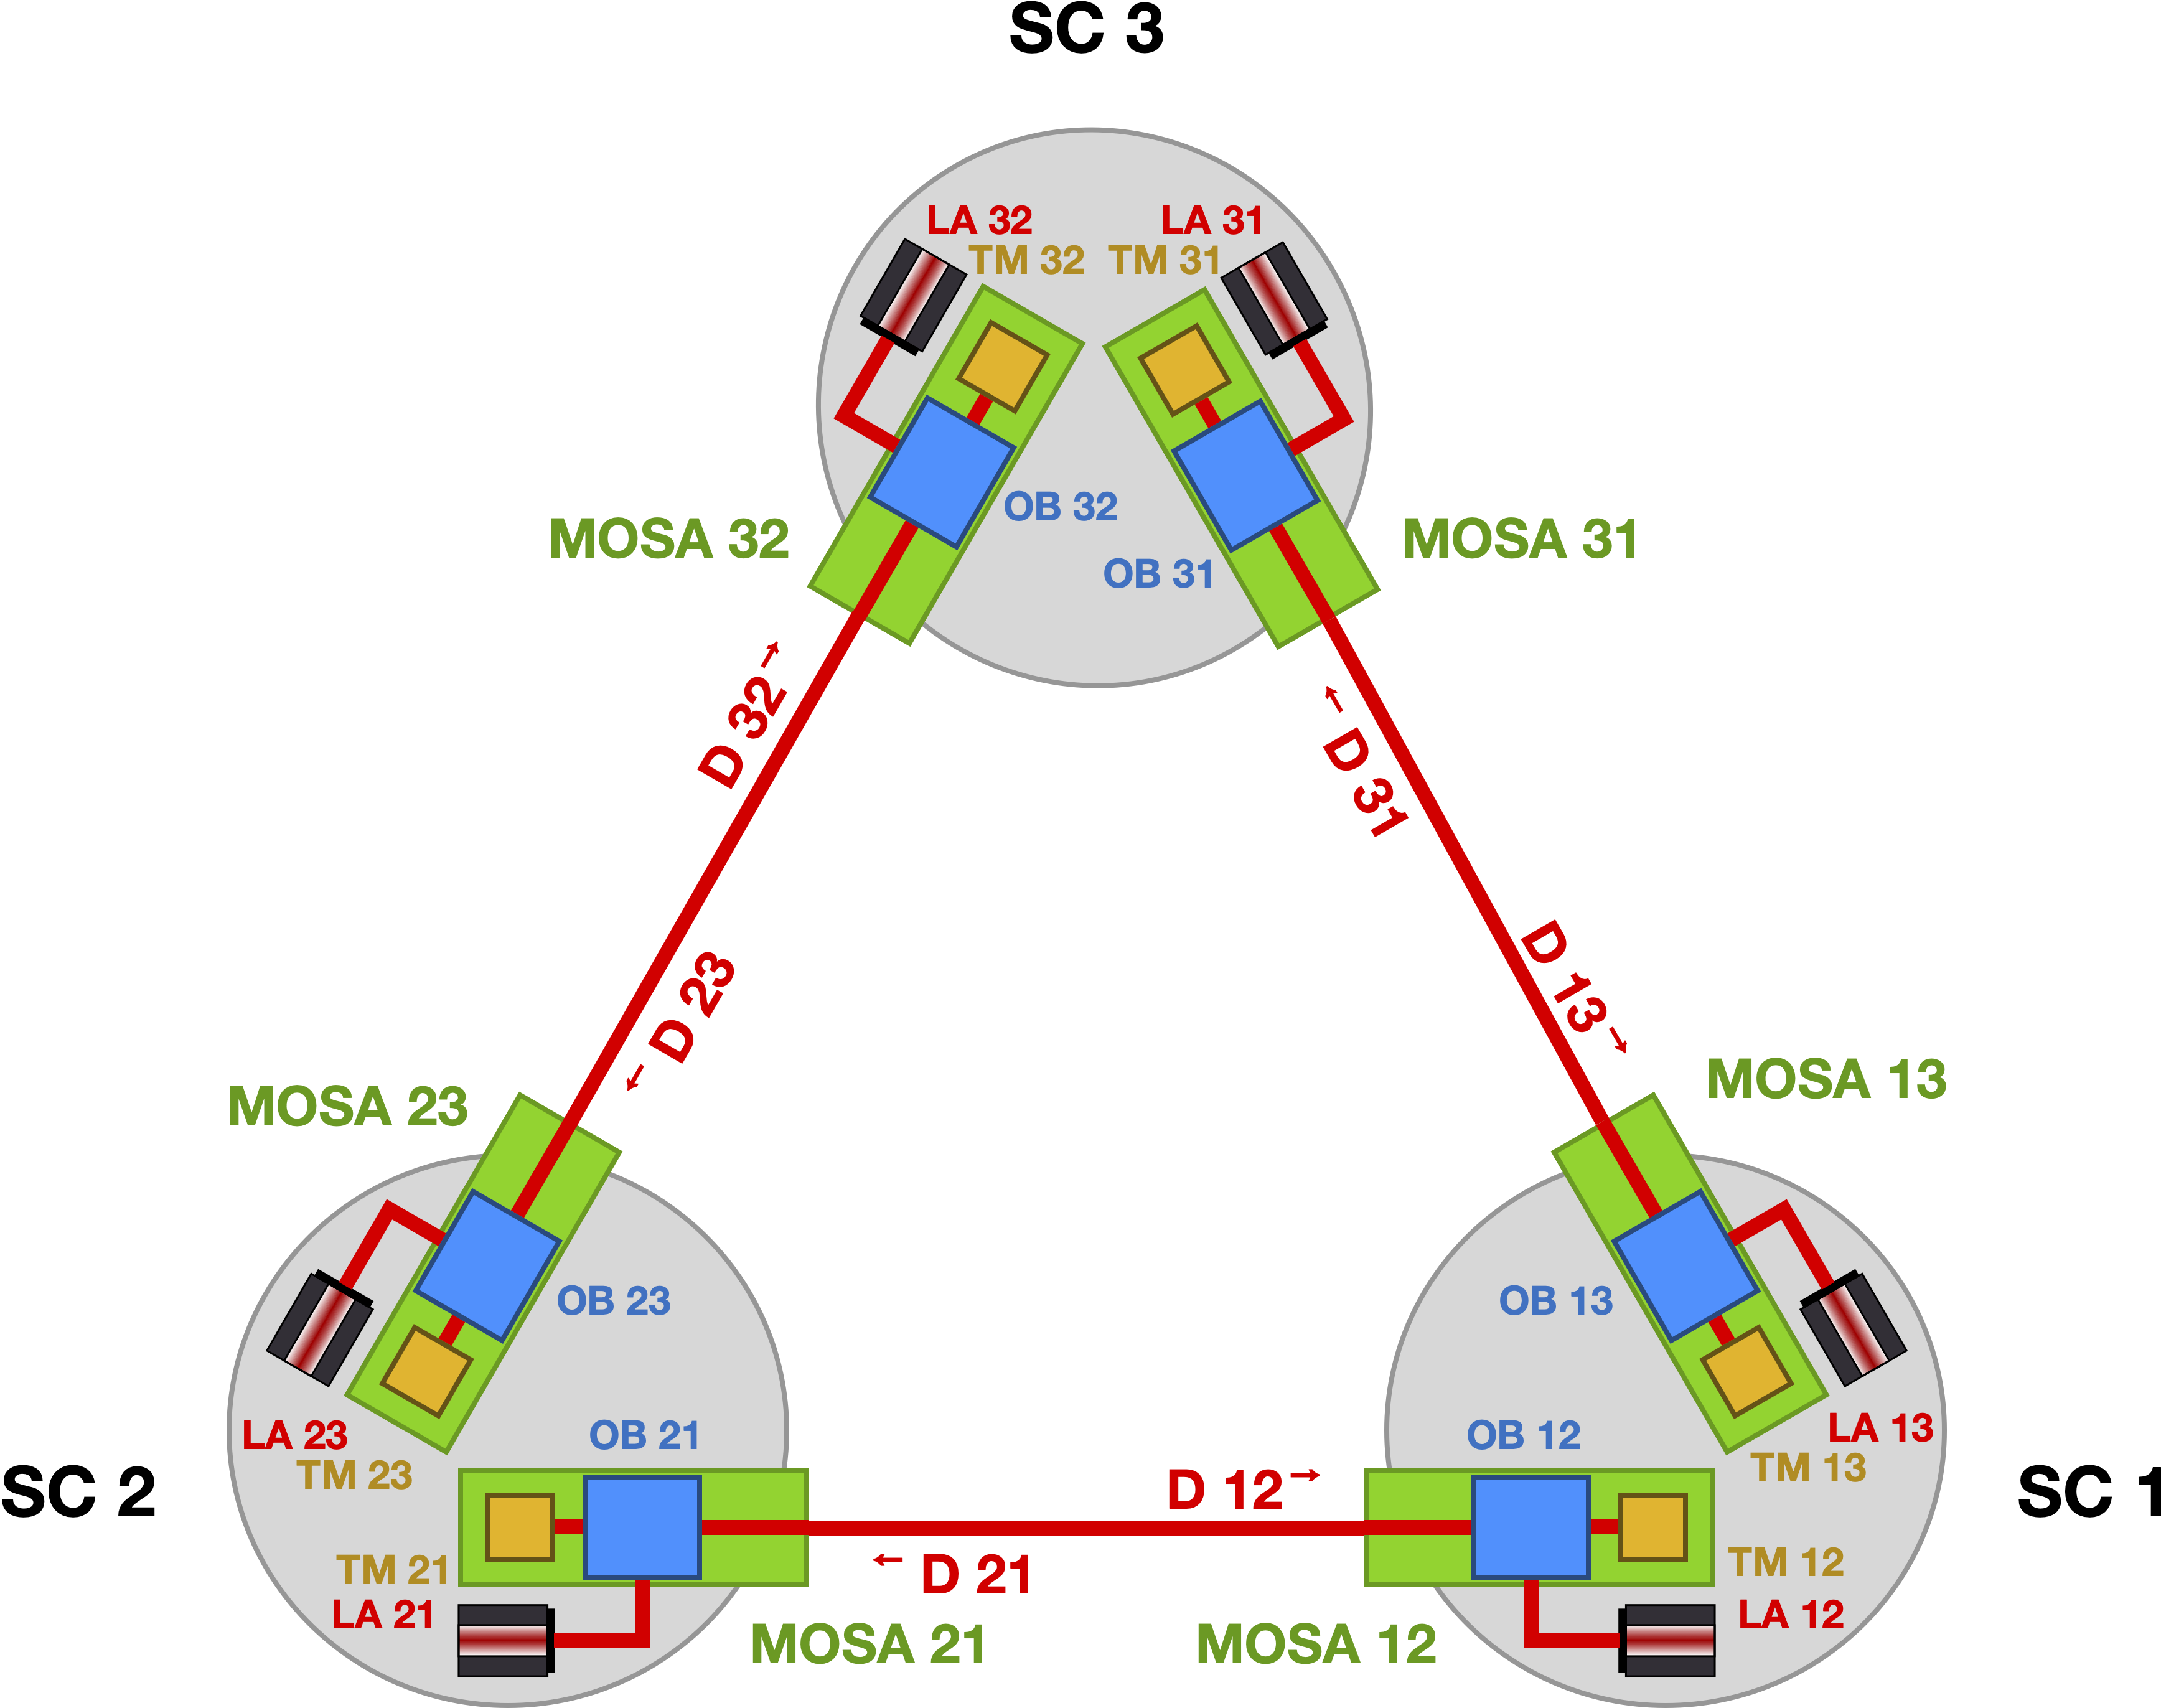

In [ ]:
# Let us see how long it takes
import time
# Check if the output file already exists
if os.path.exists(response_path):
    os.remove(response_path)
# Run simulation
t1 = time.time()
response.write(response_path,
        dt=response_dt,
        size=response_size,
        t0=response_t0,
        mode='w',
        timeframe='tcb')
logging.info("Writing complete")
t2 = time.time()
print(t2-t1)

In [ ]:
def asd(x, fs, **kwargs):
    """Compute ASD from time series.

    Args:
        x (array): time series
        fs (float): sampling frequency [Hz]
        kwargs: keyword arguments passed to scipy.signal.welch
    """
    if 'window' not in kwargs:
        kwargs['window'] = ('kaiser', 30)
    if 'nperseg' not in kwargs:
        kwargs['nperseg'] = 2**18
    if 'detrend' not in kwargs:
        kwargs['detrend'] = None
    freq, psd = welch(x, fs, **kwargs)
    return freq[5:], np.sqrt(psd[5:])

In [ ]:
with File(response_path, 'r') as hdf:

    assert response.t0 == hdf.attrs['t0']
    assert response.dt == hdf.attrs['dt']
    assert response.size == hdf.attrs['size']
    # assert response.duration == hdf.attrs['duration']

    y = hdf['tcb/y'][:]

    plt.figure(figsize=(12, 4))
    for i, mosa in enumerate(response.LINKS):
        plt.plot(response.strain_t[:1000], y[:1000, i], label=mosa)
    plt.legend()
    plt.xlabel('Time [s]')
    plt.ylabel('Link response')

    plt.figure(figsize=(12, 5))
    for i, mosa in enumerate(response.LINKS):
        f, asd_mosa = asd(y[:, i], 1/response.dt)
        plt.loglog(f, asd_mosa, label=mosa)
    plt.legend()
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Link response ASD [1/sqrt(Hz)]')

In [ ]:
### Exercise 2 ###
## Compare y12(t) and y21(2) signals, study their difference (if any) and comment.












### Exercise 2 ###

### 3.5 Apply time-delay interferometry

In [ ]:
# Same sampling as measurements
tdi_t0 = response_t0
tdi_dt = response_dt
tdi_size = response_size

In [ ]:
# TDI of SGWB signal
tdi_path_gw = os.path.join(BASEDIR, 'tdi_gw.h5')
data_gw = Data.from_gws(
    path=response_path,
    orbits=orbits_path,
    # Ignore proper times frames (using common TCB)
    gw_dataset='tcb',
    orbit_dataset='tcb/ltt',
)

# Write results
if os.path.exists(tdi_path_gw):
    os.remove(tdi_path_gw)

with File(tdi_path_gw, 'w') as hdf:

    hdf.attrs['t0'] = tdi_t0
    hdf.attrs['size'] = tdi_size
    hdf.attrs['dt'] = tdi_dt

    logging.info("Computing and writing time vector")
    hdf['t'] = response.strain_t
    logging.info("Computing and writing X2")
    hdf['X2'] = michelson.X2.build(**data_gw.args)(data_gw.measurements)
    logging.info("Computing and writing Y2")
    hdf['Y2'] = michelson.Y2.build(**data_gw.args)(data_gw.measurements)
    logging.info("Computing and writing Z2")
    hdf['Z2'] = michelson.Z2.build(**data_gw.args)(data_gw.measurements)

logging.info("Writing complete")

In [ ]:
with File(tdi_path_gw, 'r') as hdf:

    assert tdi_t0 == hdf.attrs['t0']
    assert tdi_dt == hdf.attrs['dt']
    assert tdi_size == hdf.attrs['size']

    t = hdf['t'][:]
    x2_gw = hdf['X2'][:]
    y2_gw = hdf['Y2'][:]
    z2_gw = hdf['Z2'][:]

    plt.figure(figsize=(12, 4))
    plt.plot(t[::1000], x2_gw[::1000], label='X2')
    plt.plot(t[::1000], y2_gw[::1000], label='Y2')
    plt.plot(t[::1000], z2_gw[::1000], label='Z2')
    plt.legend()
    plt.xlabel('Time [s]')
    plt.ylabel('TDI [Hz]')


    f, asd_X2 = asd(x2_gw[500:-500], 1/tdi_dt)
    f, asd_Y2 = asd(y2_gw[500:-500], 1/tdi_dt)
    f, asd_Z2 = asd(z2_gw[500:-500], 1/tdi_dt)

    _, axes = plt.subplots(1, 1, figsize=(12, 7))

    axes.loglog(f, asd_X2, label='X2')
    axes.loglog(f, asd_Y2, label='Y2')
    axes.loglog(f, asd_Z2, label='Z2')
    axes.set_ylabel(r'TDI ASD [Hz/$\sqrt{\mathrm{Hz}}$]')
    axes.legend()


    plt.subplots_adjust(hspace=0)

## 4. Simulate instrumental noise

In [ ]:
from lisaconstants import c
from lisaorbits import EqualArmlengthOrbits
from lisainstrument import Instrument
from lisainstrument.containers import ForEachMOSA
from pytdi import Data, michelson

### 4.1 Define the instrument characteristics

In [ ]:
# We offset the instrument t0 to have orbits information at emission time
instru_t0 = orbits_t0 + 100.0
instru_fs = response_fs
instru_dt = 1 / instru_fs
# Generate 1 year dataset
instru_duration = response_duration
instru_size = int(instru_duration // instru_dt) + 1
instru_path = os.path.join(BASEDIR, 'instrument.h5')
# Instantiate the instrument class
instru = Instrument(
    t0=instru_t0,
    dt=instru_dt,
    size=instru_size,
    physics_upsampling=1,
    aafilter=None,
    lock='six',
    orbits=orbits_path,
    orbit_dataset='tcb/ltt',
)

instru.disable_dopplers()
instru.disable_all_noises(excluding=['test-mass', 'oms'])
# Noise curves from LDC Spritz
instru.testmass_asds = ForEachMOSA(2.4E-15)
instru.oms_isi_carrier_asds = ForEachMOSA(7.9e-12)

### 4.2 Run instrumental simulation

In [ ]:
# Run the instrumental simulation and write the outputs
if os.path.exists(instru_path):
    os.remove(instru_path)
instru.write(instru_path, mode='w')
logging.info("Writing complete")

In [ ]:
with File(instru_path, 'r') as hdf:

    assert instru.t0 == hdf.attrs['t0']
    assert instru.dt == hdf.attrs['dt']
    assert instru.size == hdf.attrs['size']
    assert instru.duration == hdf.attrs['duration']

    isi_carrier_fluctuations = hdf['isi_carrier_fluctuations'][:]
    tmi_carrier_fluctuations = hdf['tmi_carrier_fluctuations'][:]

    plt.figure(figsize=(12, 12))
    plt.subplot(311)
    for mosa in instru.MOSAS:
        plt.plot(instru.t[::100], isi_carrier_fluctuations[mosa][::100], label=mosa)
    plt.legend()
    plt.ylabel('ISI carrier fluctuations [Hz]')

    plt.subplot(312)
    for mosa in instru.MOSAS:
        plt.plot(instru.t[::100], tmi_carrier_fluctuations[mosa][::100], label=mosa)
    plt.legend()
    plt.ylabel('TMI carrier fluctuations [Hz]')
    plt.xlabel('Time [s]')

### 4.3 Apply TDI processing


In [ ]:
tdi_path_noise = os.path.join(BASEDIR, 'tdi_noise.h5')
# TDI of instrumental noise
data = Data.from_instrument(instru_path, signals='fluctuations')

if os.path.exists(tdi_path_noise):
    os.remove(tdi_path_noise)

with File(tdi_path_noise, 'w') as hdf:

    hdf.attrs['t0'] = tdi_t0
    hdf.attrs['size'] = tdi_size
    hdf.attrs['dt'] = tdi_dt

    logging.info("Computing and writing time vector")
    hdf['t'] = instru.t
    logging.info("Computing and writing X2")
    X2 = michelson.X2.build(**data.args)
    hdf['X2'] = X2(data.measurements)
    logging.info("Computing and writing Y2")
    Y2 = michelson.Y2.build(**data.args)
    hdf['Y2'] = Y2(data.measurements)
    logging.info("Computing and writing Z2")
    Z2 = michelson.Z2.build(**data.args)
    hdf['Z2'] = Z2(data.measurements)

logging.info("Writing complete")

## 5 Data analysis: comparison with analytical models



### 5.1 Compare ISI data to OMS noise analytical model

In the inter-spacecraft interferometer (ISI, or science) carrier beatnotes, we should see the optical metrology system (OMS) noise. In terms of displacement, it's given by
$$
S_\text{oms}^\text{m}(f) = A^2 \Big[ 1 + \Big(\frac{f_\text{knee}}{f}\Big)^4 \Big].
$$
Multiplying by $(2\pi f / c)^2$ to express it as fractional frequency deviations, we can obtain the equivalent frequency shift by adding the $\nu_0^2$​ factor,
$$
S_\text{oms}^\text{Hz}(f) = \Big(\frac{2\pi f \nu_0}{c}\Big)^2 S_\text{oms}^\text{m}(f).
$$

In [ ]:
def oms_in_isi_carrier(freq, instru, mosa='12'):
    """Model for OMS noise PSD in ISI carrier beatnote fluctuations.

    Args:
        freq (float): frequencies [Hz]
        instru (Instrument): LISA instrument object
    """
    asd = instru.oms_isi_carrier_asds[mosa]
    fknee = instru.oms_fknees[mosa]
    psd_meters = asd**2 * (1 + (fknee / freq)**4)
    psd_hertz = (2 * np.pi * freq * instru.central_freq / c)**2 * psd_meters
    return np.sqrt(psd_hertz)

In [ ]:
_, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
plt.title('6 links ISI carrier fluctations amplitude spectral density:\n Simulation VS. OMS noise model')

for mosa in instru.MOSAS:
    f, asd_mosa = asd(isi_carrier_fluctuations[mosa], instru.fs)
    model = oms_in_isi_carrier(f, instru, mosa='12')
    axes[0].loglog(f, asd_mosa, label=mosa)
    # axes[1].loglog(f, np.abs(asd_mosa - model) / model, label=mosa)
    axes[1].loglog(f, asd_mosa/model, label=mosa)

axes[0].loglog(f, model, color='black', lw=2, label='model')

axes[0].legend()
axes[1].legend()
axes[1].set_xlabel('Frequency [Hz]')
axes[1].set_ylabel(r'ISI carrier fluctuations ASD [Hz/$\sqrt{\mathrm{Hz}}$]')
axes[1].set_ylabel(r'Whitened noise')
axes[1].set_ylim(1E-2, 1E1)
plt.subplots_adjust(hspace=0)

### 5.2 Compare TMI data to TM noise analytical models

In the test-mass interferometer (TMI) carrier beatnotes, we should see the test-mass noise. In terms of acceleration,
$$S_\delta^{\text{m}\,\text{s}^{-2}}(f) = A^2 [ 1 + \Big(\frac{f_\text{knee}}{f}\Big)^2 ].$$
Multiplying by $1/(2 \pi f )^2$ yields the noise as a velocity, and then dividing by c yields the noise as a Doppler shift. One needs to scale this by $2\nu_{0}$​ to get the equivalent frequency shift (the factor 2 is for the bouncing on the test mass),
$$S_\delta^\text{Hz}(f) = \Big(\frac{2 \nu_0}{2 \pi c f}\Big)^2 S_\delta^{\text{m}\,\text{s}^{-2}}(f).$$

In [ ]:
def testmass_in_tmi_carrier(freq, instru, mosa='12'):
    """Model for TM noise PSD in TMI carrier beatnote fluctuations.

    Args:
        freq (float): frequencies [Hz]
        instru (Instrument): LISA instrument object
    """
    asd = instru.testmass_asds[mosa]
    fknee = instru.testmass_fknees[mosa]
    psd_acc = asd**2 * (1 + (fknee / freq)**2)
    psd_hertz = (2 * instru.central_freq / (2 * np.pi * c * freq))**2 * psd_acc
    return np.sqrt(psd_hertz)

In [ ]:
_, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
plt.title('6 links TMI carrier fluctations amplitude spectral density:\n Simulation VS. Acceleration noise model')

for mosa in instru.MOSAS:
    f, asd_mosa = asd(tmi_carrier_fluctuations[mosa], instru.fs,
                      detrend='linear')
    model = testmass_in_tmi_carrier(f, instru, mosa='12')
    axes[0].loglog(f, asd_mosa, label=mosa)
    axes[1].loglog(f, asd_mosa / model, label=mosa)

axes[0].loglog(f, model, color='black', lw=2, label='model')

axes[0].legend()
axes[1].legend()
axes[1].set_xlabel('Frequency [Hz]')
axes[1].set_ylabel(r'TMI carrier fluctuations ASD [Hz/$\sqrt{\mathrm{Hz}}$]')
axes[1].set_ylabel(r'Whitened noise')
axes[1].set_ylim(1E-2, 1E1)
plt.subplots_adjust(hspace=0)

In [ ]:
### BONUS QUESTION ###
# There is something physically wrong in the (single-link) noise model at the moment.
# Find it ! (it's a tough one...).











### BONUS QUESTION ###

### 5.3 Compare to TDI instrumental noise model

The transfer functions through TDI are taken from [Dam Quang et al](https://arxiv.org/pdf/2211.02539.pdf). We use the common factor that depends on the average arm length L (in the code, directly given in seconds by the PPRs),
$$C_{XX}(f) = 16 \sin^2(2 \pi f L / c) \sin^2(4 \pi f L / c).$$

The transfer function for the ISI OMS noise PSD is given by
$$4 C_{XX}(f).$$

The transfer function for the test-mass noise PSD reads
$$C_{XX}(f) [3 + \cos(4 \pi f L / c)].$$

Note that the factor 2 has been removed since it's already included in the noise PSD.

Therefore, the total noise model can be written as
$$
S_{X2, n}(f) = S_{X2, \mathrm{oms}}(f) + S_{X2, \mathrm{oms}}(f){\mathrm{\delta}}(f)
$$
with
$$
\begin{align}
S_{X2, \mathrm{oms}}(f) & = 4 C_{XX}(f) S_{\mathrm{oms}}(f) \\
S_{X2, \mathrm{tm}}(f) & = C_{XX}(f) [3 + \cos(4 \pi f L / c)] S_{\mathrm{\delta}}(f)
\end{align}
$$

In [ ]:
def tdi_common(freq, instru, mosa='12'):
    """TDI common factor.

    Args:
        freq (float): frequencies [Hz]
        instru (Instrument): LISA instrument object

    Reference: https://journals.aps.org/prd/abstract/10.1103/PhysRevD.108.082004 or https://arxiv.org/pdf/2211.02539

    """
    armlength = np.mean(instru.pprs[mosa])
    result = 16 * np.sin(2 * np.pi * freq * armlength)**2 \
    * np.sin(4 * np.pi * freq * armlength)**2

    return result


def tdi_tf_oms(freq, instru, mosa='12', tdi='XYZ'):
    """TDI transfer function for ISI OMS noise.

    Args:
        freq (float): frequencies [Hz]
        instru (Instrument): LISA instrument object
    """
    if tdi=='XYZ':
      psd = 4 * tdi_common(freq, instru)
    elif tdi=='AET':
      psd = None    # Replace by correct expression
    return np.sqrt(psd)


def tdi_tf_testmass(freq, instru, mosa='12', tdi='XYZ'):
    """TDI transfer function for test mass noise.

    Args:
        freq (float): frequencies [Hz]
        instru (Instrument): LISA instrument object
    """
    armlength = np.mean(instru.pprs[mosa])
    if tdi=='XYZ':
      psd = tdi_common(freq, instru) * (3 + np.cos(4 * np.pi * freq * armlength))
    elif tdi=='AET':
      psd = None    # Replace by correct expression
    return np.sqrt(psd)

In [ ]:
with File(tdi_path_noise, 'r') as hdf:

    assert tdi_t0 == hdf.attrs['t0']
    assert tdi_dt == hdf.attrs['dt']
    assert tdi_size == hdf.attrs['size']

    x2_noise = hdf['X2'][:]
    y2_noise = hdf['Y2'][:]
    z2_noise = hdf['Z2'][:]

    plt.figure(figsize=(12, 4))
    plt.plot(instru.t[::1000], x2_noise[::1000], label='X2')
    plt.plot(instru.t[::1000], y2_noise[::1000], label='Y2')
    plt.plot(instru.t[::1000], z2_noise[::1000], label='Z2')
    plt.legend()
    plt.xlabel('Time [s]')
    plt.ylabel('TDI [Hz]')


    f, asd_x2_noise = asd(x2_noise[500:-500], instru.fs)
    f, asd_y2_noise = asd(y2_noise[500:-500], instru.fs)
    f, asd_z2_noise = asd(z2_noise[500:-500], instru.fs)

    testmass = tdi_tf_testmass(f, instru) * testmass_in_tmi_carrier(f, instru)
    oms = tdi_tf_oms(f, instru) * oms_in_isi_carrier(f, instru)
    model_noise = np.sqrt(testmass**2 + oms**2)

    _, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    axes[0].loglog(f, asd_x2_noise, label='X2')
    axes[0].loglog(f, asd_y2_noise, label='Y2')
    axes[0].loglog(f, asd_z2_noise, label='Z2')
    axes[0].loglog(f, testmass, '--', color='black', label='TM model')
    axes[0].loglog(f, oms, '--', color='gray', label='OMS model')
    axes[0].loglog(f, model_noise, color='black', lw=2, label='total noise model')
    axes[0].set_ylim(1E-11, 1E-4)
    axes[0].set_ylabel(r'TDI ASD [Hz/$\sqrt{\mathrm{Hz}}$]')
    axes[0].legend()

    axes[1].loglog(f, asd_x2_noise / model_noise, label='X2')
    axes[1].loglog(f, asd_y2_noise / model_noise, label='Y2')
    axes[1].loglog(f, asd_z2_noise / model_noise, label='Z2')
    axes[1].set_ylim(1E-2, 1E1)
    axes[1].set_xlabel('Frequency [Hz]')
    axes[1].set_ylabel(r'Whitened noise')
    axes[1].legend()

    plt.subplots_adjust(hspace=0)

In [ ]:
### EXERCISE 3 ###
# Reproduce the analysis using A, E, T TDI combinations, and CXX models from https://arxiv.org/pdf/2211.02539


















### EXERCISE 3 ###

### 5.4 Compare ISI SGWB response

The sky-averaged single-link response to gravitational waves can be computed numerically, although low-frequency approximations exist. See, for example, Babak et al., 2021 https://arxiv.org/abs/2108.01167

Here we use the analysis code delelopped in [Baghi et al. 2023](https://iopscience.iop.org/article/10.1088/1475-7516/2023/04/066).
The SGWB PSD can be written as
$$
S_{X2, \mathrm{gw}}(f) = S_{h}(f) R_{X2}(f)
$$
where $R$ is the sky-averaged response function for TDI X2:
$$
\begin{aligned}
R_{X2}\left(f, t_0\right) & = R_{X2, +}\left(f, t_0\right) + R_{X2, \times}\left(f, t_0\right) \\
R_{X2, p}\left(f, t_0\right) & = \int G_{X2, p}\left(f, t_0, \hat{\mathbf{k}}\right) G_{X2, p}^*\left(f, t_0, \hat{\mathbf{k}}\right) \mathrm{d}^2 \hat{\mathbf{k}}
\end{aligned}
$$
where $G_{X2}$ is a time and frequency dependent kernel encoding the antenna pattern.

In [ ]:
## Switch to choose whether use and analyze the data we just simulated,
## or download pre-computed ones from https://lisa-ldc.lal.in2p3.fr/file
QUICKTEST = False

In [ ]:
# We can either use the dataset we just simulated, or download a year-long dataset from the LDC website
if QUICKTEST:
  !wget "https://lisa-ldc.lal.in2p3.fr/media/uploads/cosmo/fopt-1b/tdi.h5"    # Phase transition signal
  # !wget "https://lisa-ldc.lal.in2p3.fr/media/uploads/cosmo/gb-1a/tdi.h5"     # Galactic binary confusion signal
  if not os.path.exists(f'{BASEDIR}/LDC'):
      os.mkdir(f'{BASEDIR}/LDC')
  !mv tdi.h5 data/LDC/tdi.h5

In [ ]:
if QUICKTEST:
  # Load the LDC SGWB dataset
  ldc_data_path = f'{BASEDIR}/LDC/tdi.h5'
  with File(ldc_data_path, 'r') as hdf:
      # The original dataset was missing a factor of sqrt{H0}
      x2_gw_ldc = hdf['X2'][:] * np.sqrt(H0)

In [ ]:
# Choose the size of the Welch segments
nperseg = response_size // 2
# Choose the segment overlap
noverlap = nperseg // 2
# Get the full time series size

if QUICKTEST:
    data_size = x2_gw_ldc[500:-500].size
    # Compute the signal periodogram
    f, asd_X2 = asd(x2_gw_ldc[500:-500], 1/tdi_dt, nperseg=nperseg, window="hann", noverlap=noverlap)
else:
    data_size = x2_gw[500:-500].size
    # Compute the signal periodogram
    f, asd_X2 = asd(x2_gw[500:-500], 1/tdi_dt, nperseg=nperseg, window="hann", noverlap=noverlap)

In [ ]:
# Instantiate the GW response analysis model
npixels = skymap.size
# Create a normalized map distributing the power accross the sky
skymap_model = skymap * np.sqrt(4 * np.pi / (2*npixels))
# Instantiate the SGWB object
sgwb_cls = backgrounds.StochasticBackgroundResponse(skymap_model, orbits=orbits_path)
# Create a coarse frequency grid where to compute the response
freq_grid = np.exp(np.linspace(np.log(1/tdi_dt/data_size), np.log(1/(2*tdi_dt)), 2000))
# Compute the response matrix for XYZ
g_mat_xyz = sgwb_cls.compute_tdi_kernel(freq_grid, response_t0, tdi_var='aet', gen='2.0', parallel=True)

In [ ]:
# Compute the SGWB PSD
sh = energy_density_psd(f)
# Build the sky-averaged GW response function by interpolating
r_function = interp1d(freq_grid, g_mat_xyz[:, 0, 0].real, kind="cubic",
                      fill_value="extrapolate")
# Compute the TDI response to the SGWB
tdi_model_gw = np.sqrt(sh * r_function(f))

In [ ]:
_, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True,
                       gridspec_kw={'height_ratios': [2, 1]})

axes[0].loglog(f, asd_X2, label='X2')
axes[0].loglog(f, tdi_model_gw, color='black', lw=2, label='model')
axes[0].set_ylim(1E-26, 1E-20)
axes[0].set_ylabel(r'TDI ASD [$\mathrm{Hz^{-1/2}}$]')
axes[0].legend()

axes[1].loglog(f, asd_X2 / tdi_model_gw, label='X2')
axes[1].set_ylim(1E-2, 1E1)
axes[1].set_xlabel('Frequency [Hz]')
axes[1].set_ylabel(r'Whitened noise')
axes[1].legend()

### 5.5 Compare noise and signal

In [ ]:
# We can either use the dataset we just simulated, or download a year-long dataset from the LDC website
if QUICKTEST:
  !wget "https://lisa-ldc.lal.in2p3.fr/media/uploads/cosmo/noise-1a/tdi.h5"
  if not os.path.exists(f'{BASEDIR}/LDC'):
      os.mkdir(f'{BASEDIR}/LDC')
  !mv tdi.h5 data/LDC/tdi_noise.h5

In [ ]:
# Similarly, instead of analysing the noise we generated, we download a year-long simulation.
if QUICKTEST:
  ldc_noise_path = f'{BASEDIR}/LDC/tdi_noise.h5'

  with File(ldc_noise_path, 'r') as hdf:
      x2_noise_ldc = hdf['X2'][:]

In [ ]:
# Convert everything in relative frequency deviations
if QUICKTEST:
    x2 = x2_noise_ldc / instru.central_freq + x2_gw_ldc
else:
    x2 = x2_noise / instru.central_freq + x2_gw

In [ ]:
f, asd_x2 = asd(x2[500:-500], 1/tdi_dt, nperseg=nperseg, window="hann", noverlap=noverlap)

In [ ]:
# Noise PSD model
testmass = tdi_tf_testmass(f, instru) * testmass_in_tmi_carrier(f, instru)
oms = tdi_tf_oms(f, instru) * oms_in_isi_carrier(f, instru)
model_noise = np.sqrt(testmass**2 + oms**2)
# Full TDI model
tdi_model = np.sqrt((model_noise/instru.central_freq)**2 + tdi_model_gw**2)

In [ ]:
_, axes = plt.subplots(1, 1, figsize=(12, 7))

axes.loglog(f, asd_x2, label='X2')
axes.loglog(f, tdi_model, color='black', lw=2, label='Total model')
axes.loglog(f, tdi_model_gw, color='tab:red', lw=2, label='GW model')
axes.loglog(f, model_noise/instru.central_freq, color='gray', lw=2, linestyle="dashed", label='Noise model')
axes.set_ylim(1E-25, 1E-18)
axes.set_xlim(1E-4, 1E-1)
axes.set_ylabel(r'TDI ASD [$\mathrm{Hz^{-1/2}}$]')
axes.legend()
